In [4]:
import pandas as pd

# this crates a very simple dataset where a description maps to a price
df = pd.read_csv("data.csv")
df = df[["description", "price"]]

# remove all the genius discount information
for i in range(df.shape[0]):
    description = df.loc[i, "description"]
    if "Genius discount" in description:
        df.loc[i, "description"] = " ".join(df.loc[i, "description"].split("\n")[1:])
    else:
        df.loc[i, "description"] = " ".join(df.loc[i, "description"].split("\n"))

# limit to 50 words of each description
for i in range(df.shape[0]):
    description = df.loc[i, "description"]
    df.loc[i, "description"] = " ".join(df.loc[i, "description"].split(" ")[:50])

df

,description,price
0,"The State Hotel features a fitness center, ter...",6.212606
1,Hotel Theodore is a nonsmoking hotel located i...,5.826000
2,"Located in Central Seattle, Kimpton Hotel Mona...",6.084499
3,Less than 10 minutes’ drive from the Space Nee...,6.061457
4,"Attractively set in Seattle, citizenM Seattle ...",5.937536
...,...,...
3054,"Located in Apopka, Florida, this hotel offers ...",5.062595
3055,"Featuring free WiFi, Hyatt Place Orlando Lake ...",5.446737
3056,"Only 1 mi from Universal Studios Florida™, thi...",5.187386
3057,"Experience all of the comforts of home, includ...",5.327876


In [5]:
from transformers import AutoModel, AutoTokenizer

# load distilbert using huggingface transformers
model_ckpt = "distilbert-base-uncased"
device = "cpu"
model = AutoModel.from_pretrained(model_ckpt).to(device)

# select the tokenizer that we are using
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
inputs = tokenizer(df["description"].tolist(), return_tensors="pt", padding=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
import torch

inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-2.3708e-01, -2.3492e-02,  1.8794e-01,  ...,  3.5607e-02,
           3.2778e-01,  3.1167e-01],
         [-5.1986e-01, -1.5868e-01, -7.6253e-02,  ...,  7.2493e-01,
           1.3479e+00, -1.9877e-01],
         [-2.7865e-01, -2.2134e-01,  4.7810e-01,  ...,  1.2907e-01,
           1.6998e-01,  1.9531e-01],
         ...,
         [-3.7749e-01,  9.0538e-02,  2.8604e-01,  ...,  1.4125e-01,
           6.6137e-02,  4.3065e-01],
         [ 2.1944e-01, -5.3321e-02,  2.6487e-01,  ...,  2.6372e-02,
           1.2872e-02,  6.1563e-02],
         [ 2.1706e-01, -5.3119e-02,  2.7640e-01,  ...,  5.3825e-02,
           3.0555e-03,  5.7566e-02]],

        [[-2.5935e-01, -1.5205e-02,  8.0381e-04,  ...,  1.5162e-01,
           5.2034e-01,  2.7812e-01],
         [ 4.3375e-01,  8.5137e-02, -7.0369e-02,  ...,  1.2842e-01,
           1.1190e+00,  3.5222e-01],
         [ 1.6665e-01,  3.2891e-01, -1.6947e-02,  ...,  7.8440e-02,
           2.4559e-01,  2.9680e-01],
     

In [7]:
# extract the CLS of each sentence
latent_space = outputs.last_hidden_state[:, 0].numpy()
price = df['price'].to_numpy()
latent_space.shape, price.shape

((3059, 768), (3059,))

Score: 0.4633023819219483


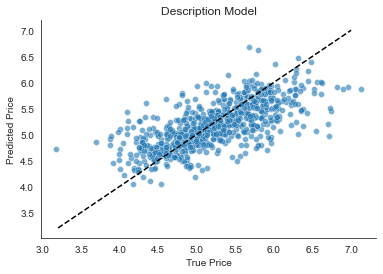

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# run linear regression
X, y = latent_space, price
X = PCA(n_components=64).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
predicted = reg.predict(X_test)
print("Score:", reg.score(X_test, y_test))

# plot the data
sns.set_style("white")
sns.set_palette("tab10")
sns.scatterplot(x=y_test, y=predicted, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Description Model")
sns.despine()
plt.savefig("../figures/description_model.png", dpi=200)
plt.show()